# NYSE FANG+ index 日足 メディアン統計

In [1]:
import sys
path_up = '..'
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf

from funcs.technical import calc_robust_bollinger

code = 'NYFANG'
symbol = '^%s' % code
#symbol = 'USDJPY=X'
ticker = yf.Ticker(symbol)
df = ticker.history(period='1y', interval='1d')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-03-21 00:00:00-04:00,10064.070312,10207.280273,10040.320312,10043.469727,0,0.0,0.0
2024-03-22 00:00:00-04:00,10043.469727,10137.169922,10006.709961,10113.120117,0,0.0,0.0
2024-03-25 00:00:00-04:00,10113.120117,10124.799805,10026.709961,10088.129883,0,0.0,0.0
2024-03-26 00:00:00-04:00,10088.129883,10195.070312,10047.690430,10050.230469,0,0.0,0.0
2024-03-27 00:00:00-04:00,10050.230469,10128.669922,9964.540039,10040.740234,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-14 00:00:00-04:00,11680.030273,12073.919922,11680.030273,12057.169922,0,0.0,0.0
2025-03-17 00:00:00-04:00,12057.169922,12209.969727,11998.240234,12092.110352,0,0.0,0.0
2025-03-18 00:00:00-04:00,12092.110352,12092.110352,11750.429688,11850.049805,0,0.0,0.0


In [3]:
df0 = ticker.history(period='3y', interval='1d')
df0

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-03-21 00:00:00-04:00,6434.229980,6460.120117,6278.669922,6392.700195,0,0.0,0.0
2022-03-22 00:00:00-04:00,6392.700195,6653.000000,6392.700195,6625.990234,0,0.0,0.0
2022-03-23 00:00:00-04:00,6625.990234,6720.390137,6527.649902,6581.189941,0,0.0,0.0
2022-03-24 00:00:00-04:00,6581.189941,6684.959961,6499.680176,6683.759766,0,0.0,0.0
2022-03-25 00:00:00-04:00,6683.759766,6683.759766,6545.899902,6650.040039,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-14 00:00:00-04:00,11680.030273,12073.919922,11680.030273,12057.169922,0,0.0,0.0
2025-03-17 00:00:00-04:00,12057.169922,12209.969727,11998.240234,12092.110352,0,0.0,0.0
2025-03-18 00:00:00-04:00,12092.110352,12092.110352,11750.429688,11850.049805,0,0.0,0.0


## Moving Median

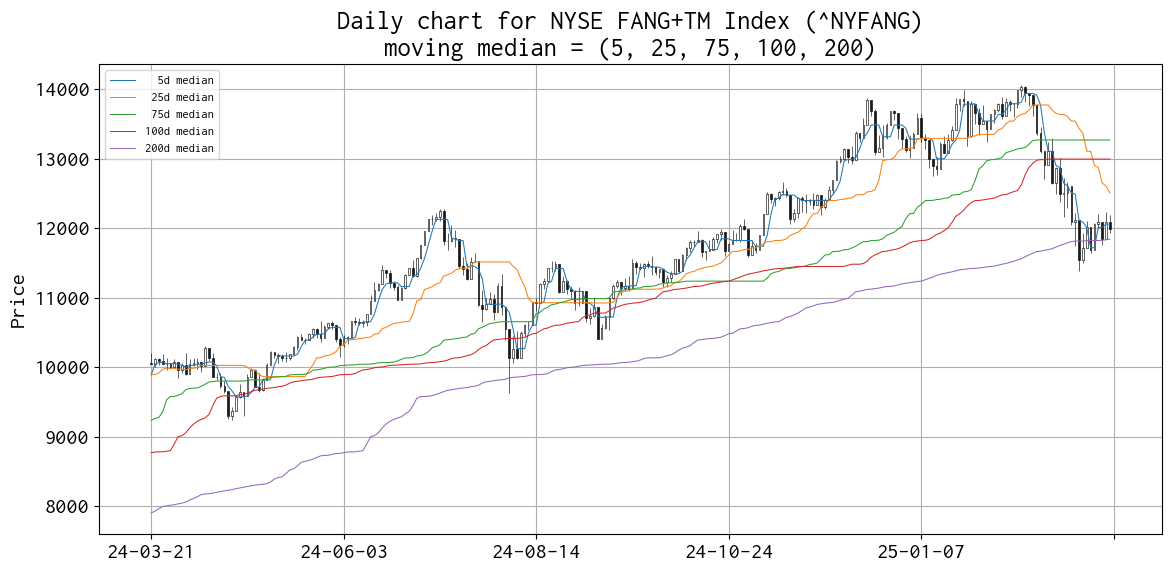

In [4]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 6))

mm005 = df0['Close'].rolling(5).median()
mm025 = df0['Close'].rolling(25).median()
mm075 = df0['Close'].rolling(75).median()
mm100 = df0['Close'].rolling(100).median()
mm200 = df0['Close'].rolling(200).median()

apds  = [
    mpf.make_addplot(mm005[df.index], width=0.75, label='  5d median', ax=ax),
    mpf.make_addplot(mm025[df.index], width=0.75, label=' 25d median', ax=ax),
    mpf.make_addplot(mm075[df.index], width=0.75, label=' 75d median', ax=ax),
    mpf.make_addplot(mm100[df.index], width=0.75, label='100d median', ax=ax),
    mpf.make_addplot(mm200[df.index], width=0.75, label='200d median', ax=ax),
]   

mpf.plot(
    df, type='candle', style='default',
    datetime_format='%y-%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)
ax.set_title('Daily chart for %s (%s)\nmoving median = (5, 25, 75, 100, 200)' %(ticker.info['longName'], symbol))
ax.grid()
ax.legend(loc='best', fontsize=9)

plt.tight_layout()
plt.savefig('report_daily_chart_median_%s.png' % code)
plt.show()

In [5]:
df.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-03-19 00:00:00-04:00,11850.049805,12225.120117,11844.940430,12085.929688,0,0.0,0.0
2025-03-20 00:00:00-04:00,12085.929688,12187.849609,11927.839844,11990.900391,0,0.0,0.0


In [6]:
df.tail(2)['Close']

Date
2025-03-19 00:00:00-04:00    12085.929688
2025-03-20 00:00:00-04:00    11990.900391
Name: Close, dtype: float64

In [7]:
df.tail(2)['Close'].diff()

Date
2025-03-19 00:00:00-04:00          NaN
2025-03-20 00:00:00-04:00   -95.029297
Name: Close, dtype: float64

In [8]:
df['Close'].tail(1) - df['Open'].tail(1)

Date
2025-03-20 00:00:00-04:00   -95.029297
dtype: float64

In [9]:
df['Close'].rolling(9).median().tail()

Date
2025-03-14 00:00:00-04:00    12057.169922
2025-03-17 00:00:00-04:00    12057.169922
2025-03-18 00:00:00-04:00    12009.730469
2025-03-19 00:00:00-04:00    12009.730469
2025-03-20 00:00:00-04:00    11990.900391
Name: Close, dtype: float64

In [10]:
df['Close'].rolling(13).median().tail()

Date
2025-03-14 00:00:00-04:00    12109.650391
2025-03-17 00:00:00-04:00    12092.110352
2025-03-18 00:00:00-04:00    12087.469727
2025-03-19 00:00:00-04:00    12085.929688
2025-03-20 00:00:00-04:00    12057.169922
Name: Close, dtype: float64

In [11]:
df['Close'].rolling(26).median().tail()

Date
2025-03-14 00:00:00-04:00    13003.369629
2025-03-17 00:00:00-04:00    12886.839844
2025-03-18 00:00:00-04:00    12760.595215
2025-03-19 00:00:00-04:00    12627.370117
2025-03-20 00:00:00-04:00    12556.665039
Name: Close, dtype: float64

In [12]:
df['Close'].rolling(52).median().tail()

Date
2025-03-14 00:00:00-04:00    13309.865234
2025-03-17 00:00:00-04:00    13286.464844
2025-03-18 00:00:00-04:00    13280.180176
2025-03-19 00:00:00-04:00    13280.180176
2025-03-20 00:00:00-04:00    13280.180176
Name: Close, dtype: float64

## Robust Bollinger's bands

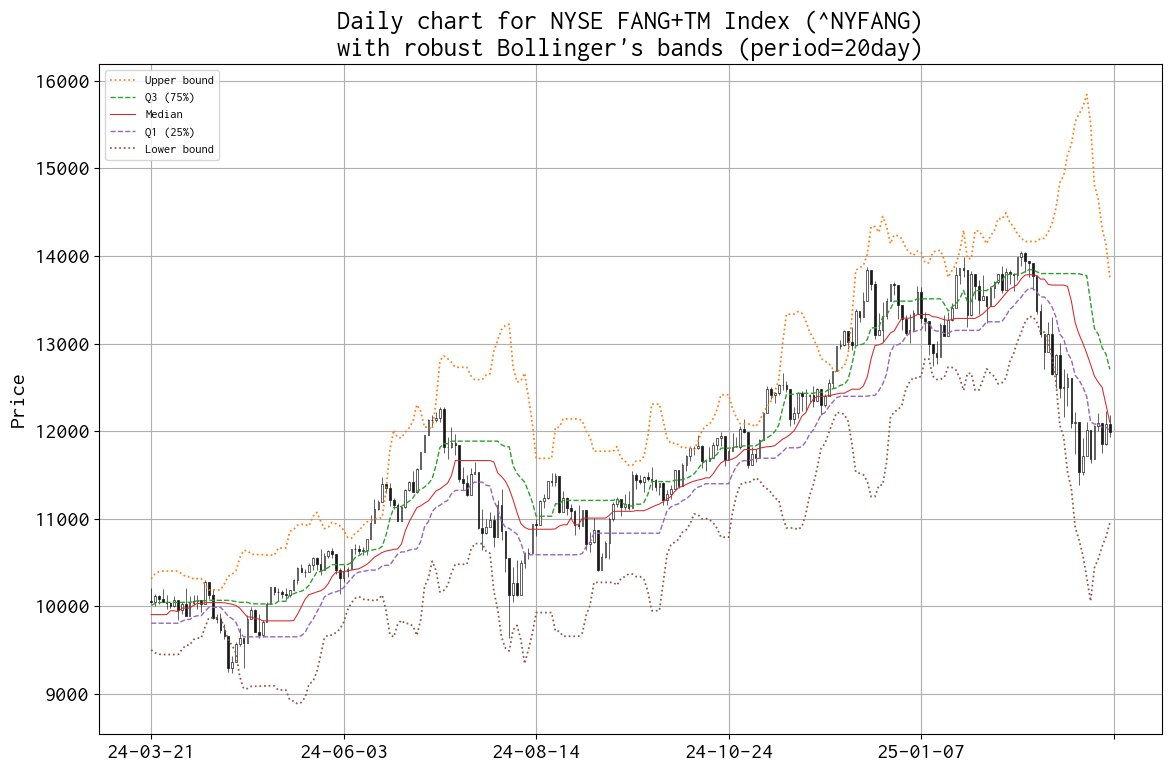

In [13]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 8))

# Bollinger bands
period = 20
mv_median = df0['Close'].rolling(period).median()
mv_q1 = df0['Close'].rolling(period).quantile(.25)
mv_q3 = df0['Close'].rolling(period).quantile(.75)
mv_iqr = mv_q3 - mv_q1
mv_lower = mv_q1 - mv_iqr * 1.5
mv_upper = mv_q3 + mv_iqr * 1.5

apds  = [
    mpf.make_addplot(mv_upper[df.index], width=1.25, color='C1', linestyle='dotted', label='Upper bound', ax=ax),
    mpf.make_addplot(mv_q3[df.index], width=1, color='C2', linestyle='dashed', label='Q3 (75%)', ax=ax),
    mpf.make_addplot(mv_median[df.index], width=0.75, color='C3', label='Median', ax=ax),
    mpf.make_addplot(mv_q1[df.index], width=1, color='C4', linestyle='dashed', label='Q1 (25%)', ax=ax),
    mpf.make_addplot(mv_lower[df.index], width=1.25, color='C5', linestyle='dotted', label='Lower bound', ax=ax),
]   

mpf.plot(
    df, type='candle', style='default',
    addplot=apds,
    datetime_format='%y-%m-%d',
    xrotation=0,
    ax=ax,
)

ax.grid()
ax.legend(loc='best', fontsize=9)

try:
    ax.set_title('Daily chart for %s (%s)\nwith robust Bollinger bands (period=%dday)' % (ticker.info['longName'], symbol, period))
except KeyError:
    ax.set_title('Daily chart for %s\nwith robust Bollinger bands (period=%dday)' % (symbol, period))

plt.tight_layout()
plt.savefig('report_daily_chart_bollinger_robust_%s.png' % code)
plt.show()

## ヒストグラム

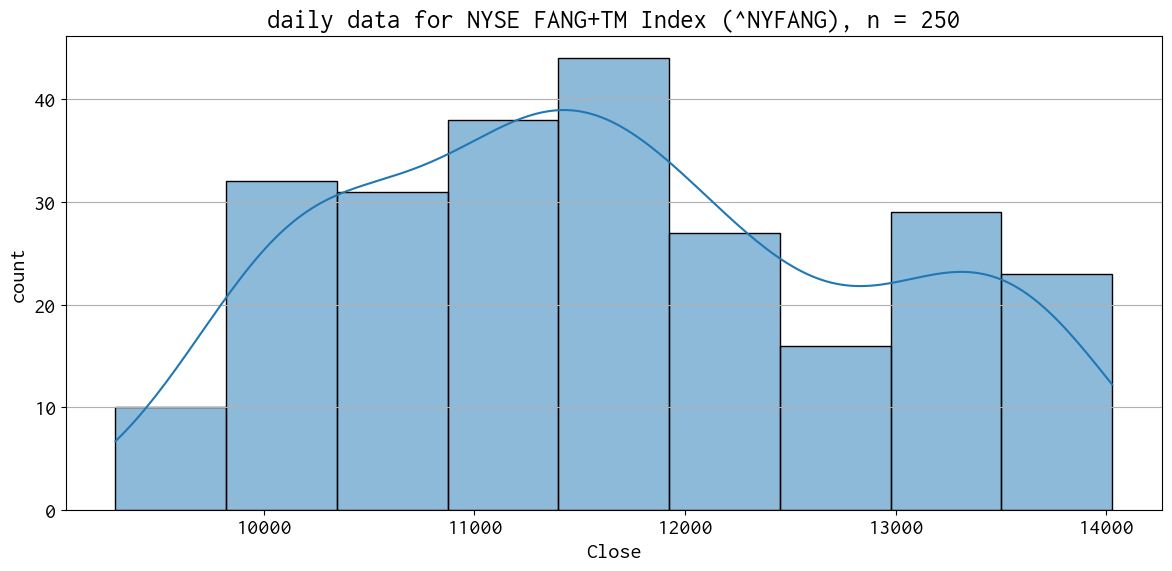

In [14]:
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(12, 6))
#ax = fig.add_axes(111)
ax = fig.add_subplot(111)

sns.histplot(
    df['Close'],
    kde=True,
    ax=ax
)

ax.set_xlabel("Close")
ax.set_ylabel("count")
ax.set_title('daily data for %s (%s), n = %d' % (ticker.info['longName'], symbol, len(df)))
ax.grid(axis = 'y')

plt.tight_layout()
plt.savefig('report_daily_histogram_%s.png' % code)
plt.show()